In [254]:
import os

#os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
#import modin.pandas as pd
#import ray

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import json

#ray.init(ignore_reinit_error=True)

In [255]:
%matplotlib inline
sns.set(font_scale=1.25)
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
matplotlib.rcParams.update({'figure.autolayout': True})

In [256]:
raptor_dist = [0, 10241, 491582, 712794, 831695, 831695, 831695, 831695, 831695, 831695, 948446, 1032189, 1032189,
               1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189,
               1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189, 1032189,
               1032189, 1032189, 1032189, 1032189, 1032189, 1048576]


def load_json(filename):
    with open(filename) as f:
        json_diff = json.load(f)
    return json_diff


from Helper import encode, to_dist_list, norm_list
import Distribution


def recalculate_for_dist(df, seed_spacing=0, use_payload_xor=False, use_raptor_dist=False):
    files = df["file_lst"]
    chunksize = df["chunksize"]
    overhead_fac = df["overhead_fac"]
    avg_error_fac = df["avg_error_fac"]
    clean_deg_len_fac = df["clean_deg_len_fac"]
    clean_avg_error_fac = df["clean_avg_error_fac"]
    non_unique_packets_fac = df.get("non_unique_packets_fac")
    # df["unique_packets_fac"]
    seed_spacing = df.get("seed_space", seed_spacing)
    use_payload_xor = df.get("use_payload_xor", use_payload_xor)
    unrecovered_packets_fac = df["unrecovered_packets_fac"]
    repeats = df["repeats"]
    if "finished_prev_best" in df:
        dist_func = df["finished_prev_best"]["dist_lst"]
    else:
        dist_func = df["finished_gen"][-1]["dist_lst"]
    if use_raptor_dist:
        dist_func = norm_list(to_dist_list(raptor_dist))

    # create all packets for the dist:
    dist = Distribution.Distribution(dist_func, overhead_fac=overhead_fac,
                                     avg_error_fac=avg_error_fac, clean_deg_len_fac=clean_deg_len_fac,
                                     clean_avg_error_fac=clean_avg_error_fac,
                                     non_unique_packets_fac=non_unique_packets_fac,
                                     unrecovered_packets_fac=unrecovered_packets_fac, seed_spacing=seed_spacing,
                                     use_payload_xor=use_payload_xor)

    dist.compute_fitness(files, repeats, chunksize)
    dist.calculate_error_value()
    return dist

# Set correct parameter below:

# ! IMPORTANT: the "results" folder is NOT part of the repository, as it contains the results of the experiments!
## it can be downloaded from using following link: https://<todo>

In [257]:
base_dir = "./results"
#working_dir = "results_DornRapunzel"
#working_dir = "results_no_improv_new"
#working_dir = "results_final_same_params"
working_dir = "results_bmp_low_entropy"
#filename = "results_evo/evo_opt_state.json"
filename = "results_diff/diff_opt_state.json/diff_opt_state.json"
img_format = "_10_5" # only "_10_5" or "" supported by now...

# possible combinations:
# working_dir x filename x img_format (4 x 2 x 2 = 16 combinations currently used)

if "evo_opt" in filename:
    opt_type = "evolutionary optimization"
elif "GrdOpt" in filename:
    opt_type = "gradient descent"  # TODO: check!
elif "results_diff" in filename:
    opt_type = "differential evolution"
else:
    opt_type = "unknown optimization type"

json_diff = load_json(f"{base_dir}/{working_dir}/{filename}")
# we should use more samples for the default raptor dist to even out outliers for the overhead (however, changing the sample count to a value other that the value used during the experiment is not a good approach either!)

# WARNING: ensure that ALL rules match the rules used during the optimization, otherwise the results will be wrong!
raptor_res = recalculate_for_dist(json_diff, use_raptor_dist=True).to_json()

Creating packet 0 / 65536
Creating packet 0 / 65536
Creating packet 0 / 65536


Saved as results_bmp_low_entropy_results_diff_results_non_unique_10_5.svg/pdf
Saved as results_bmp_low_entropy_results_diff_results_rule_abiding_packet_10_5.svg/pdf
Saved as results_bmp_low_entropy_results_diff_results_avg_unrecovered_10_5.svg/pdf


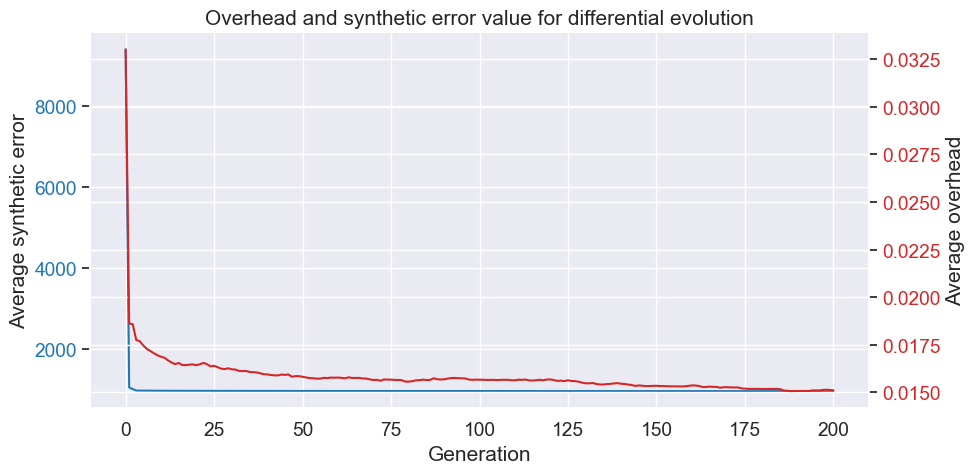

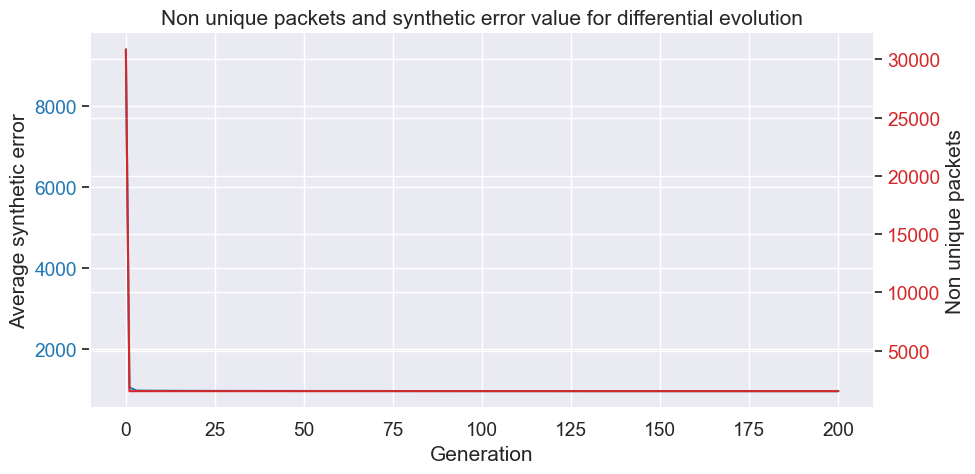

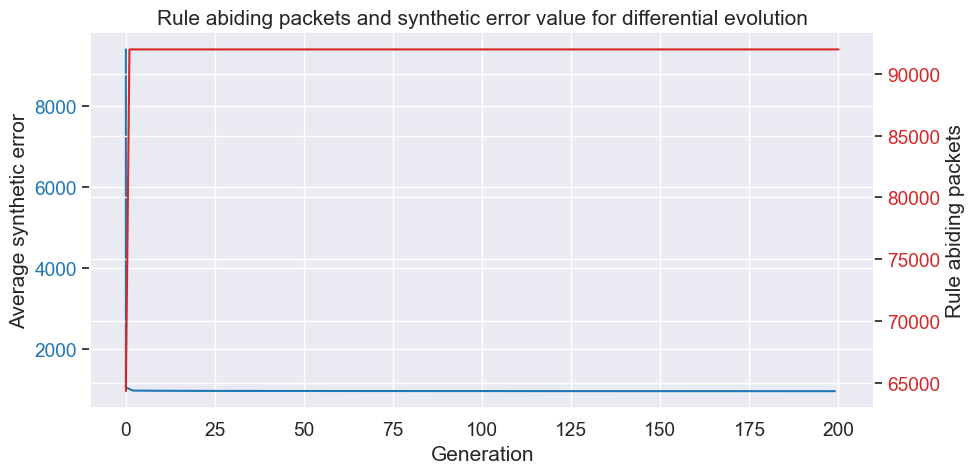

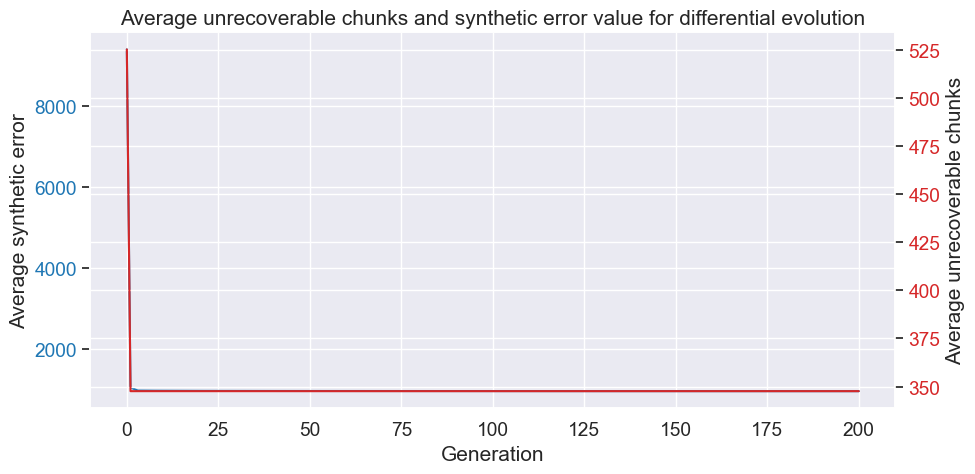

In [258]:

# Overhead and Synthetic Error Value for Evolutionary Optimization
if img_format != "":
    fig, ax1 = plt.subplots(figsize=(10, 5))
else:
    fig, ax1 = plt.subplots()

ax1.set_title(f"Overhead and synthetic error value for {opt_type}")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Average synthetic error")
df_diff = pd.DataFrame(json_diff["gen_calculated_error"])
df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
df_diff = df_diff.reset_index(drop=True)
ax1.plot(df_diff, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Average overhead")
df_diff = pd.DataFrame(json_diff["gen_avg_over"])
df_diff = pd.concat([pd.DataFrame([raptor_res])["overhead"], df_diff])
df_diff = df_diff.reset_index(drop=True)
# df_diff = pd.DataFrame(json_diff["gen_avg_err"])
ax2.plot(df_diff, color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.tight_layout()

plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_overhead{img_format}.svg", format="svg", dpi=1200)
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_overhead{img_format}.pdf", bbox_inches="tight")

# Non unique packets and synthetic error value for Evolutionary Optimization

if img_format != "":
    fig, ax1 = plt.subplots(figsize=(10, 5))
else:
    fig, ax1 = plt.subplots()

ax1.set_title(f"Non unique packets and synthetic error value for {opt_type}")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Average synthetic error")
df_diff = pd.DataFrame(json_diff["gen_calculated_error"])
df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
df_diff = df_diff.reset_index(drop=True)
df_diff_calc_err = df_diff
ax1.plot(df_diff, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Non unique packets")
df_a = pd.DataFrame(json_diff["gen_best_dist"])
df_a = pd.concat([pd.DataFrame([raptor_res]), df_a])
df_a = df_a.reset_index(drop=True)
df_diff = pd.DataFrame(df_a["non_unique_packets"])

ax2.plot(df_diff, color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.tight_layout()

plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_non_unique{img_format}.svg", format="svg", dpi=1200)
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_non_unique{img_format}.pdf", bbox_inches="tight")
print(f"Saved as {working_dir}_{filename.split('/')[0]}_results_non_unique{img_format}.svg/pdf")

# rule abiding packets and synthetic error value for Evolutionary Optimization
if img_format != "":
    fig, ax1 = plt.subplots(figsize=(10, 5))
else:
    fig, ax1 = plt.subplots()

ax1.set_title(f"Rule abiding packets and synthetic error value for {opt_type}")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Average synthetic error")
df_diff = pd.DataFrame(json_diff["gen_calculated_error"])
df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
df_diff_calc_err = df_diff
ax1.plot(df_diff, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Rule abiding packets")
df_diff = pd.DataFrame(df_a["clean_deg_len"])
ax2.plot(df_diff, color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.tight_layout()

plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_rule_abiding_packet{img_format}.svg", format="svg",
            dpi=1200)
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_rule_abiding_packet{img_format}.pdf", bbox_inches="tight")
print(f"Saved as {working_dir}_{filename.split('/')[0]}_results_rule_abiding_packet{img_format}.svg/pdf")

# avg_unrecovered packets and synthetic error value for Evolutionary Optimization
if img_format != "":
    fig, ax1 = plt.subplots(figsize=(10, 5))
else:
    fig, ax1 = plt.subplots()

ax1.set_title(f"Average unrecoverable chunks and synthetic error value for {opt_type}")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Average synthetic error")
df_diff = pd.DataFrame(json_diff["gen_calculated_error"])
df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
df_diff = df_diff.reset_index(drop=True)
df_diff_calc_err = df_diff
ax1.plot(df_diff, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Average unrecoverable chunks")
df_diff = pd.DataFrame(df_a["avg_unrecovered"])
ax2.plot(df_diff, color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.tight_layout()

plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_avg_unrecovered{img_format}.svg", format="svg", dpi=1200)
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_avg_unrecovered{img_format}.pdf", bbox_inches="tight")

print(f"Saved as {working_dir}_{filename.split('/')[0]}_results_avg_unrecovered{img_format}.svg/pdf")

## plot the optimized distribution function:

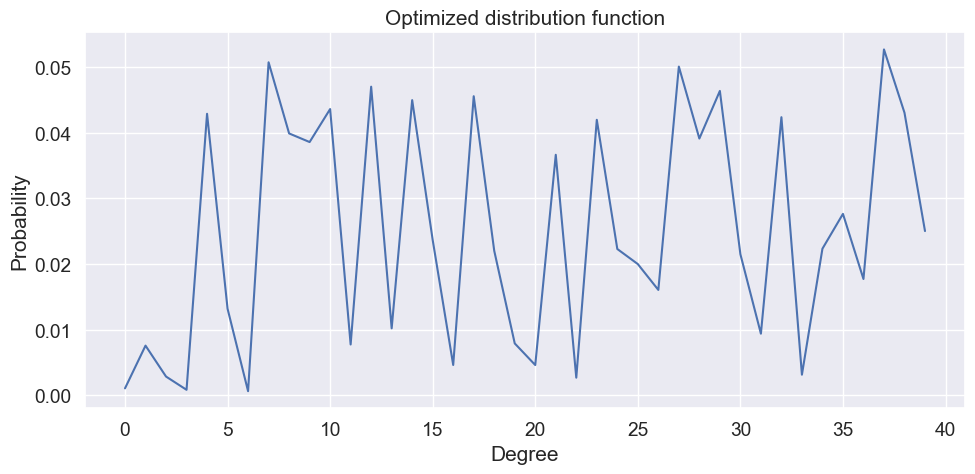

In [259]:
if img_format != "":
    fig, ax1 = plt.subplots(figsize=(10, 5))
else:
    fig, ax1 = plt.subplots()
ax1.set_title("Optimized distribution function")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Probability")
# ax1.plot(df_diff, color="tab:blue")
ax1.plot(json_diff["gen_best_dist"][-1]["dist_lst"])
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_diff_opt_dist{img_format}.svg", format="svg", dpi=1200)
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_diff_opt_dist{img_format}.pdf", bbox_inches="tight")

Saved as results_bmp_low_entropy_results_diff_results_degree_vs_degree_error_10_5


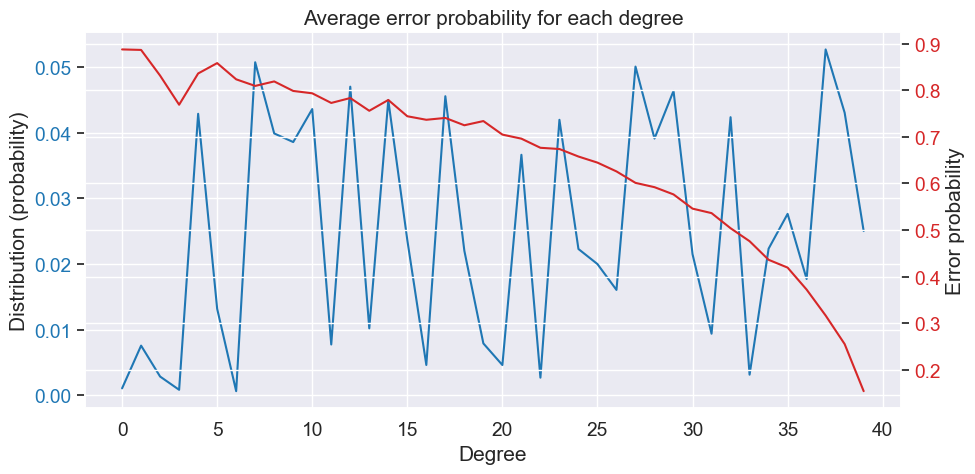

In [260]:
if img_format != "":
    fig, ax1 = plt.subplots(figsize=(10, 5))
else:
    fig, ax1 = plt.subplots()
ax1.set_title("Average error probability for each degree")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Distribution (probability)")
# df_diff = pd.DataFrame(json_diff["gen_best_dist"][-1]["dist_lst"])
ax1.plot(json_diff["gen_best_dist"][-1]["dist_lst"], color="tab:blue")

ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Error probability")
ax2.plot(json_diff["gen_best_dist"][-1]["degree_errs"], color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.tight_layout()

plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_degree_vs_degree_error{img_format}.svg", format="svg", dpi=1200)
plt.savefig(f"{working_dir}_{filename.split('/')[0]}_results_degree_vs_degree_error{img_format}.pdf", bbox_inches="tight")
print(f"Saved as {working_dir}_{filename.split('/')[0]}_results_degree_vs_degree_error{img_format}")

## Comparision of the different optimization algorithms:

In [261]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

base_dir = "./results"
# working dir and prefix for algorithm comparison:
working_dir = "results_bmp_low_entropy"
working_dir = "cmp_results"

evo_cmp_mut_0.1
Creating packet 0 / 65536
evo_cmp_mut_0.2
evo_cmp_mut_0.3
evo_cmp_mut_0.4
evo_cmp_mut_0.5


C:\TEMP\ipykernel_33760\2235913213.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.draw()
C:\TEMP\ipykernel_33760\2235913213.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
C:\TEMP\ipykernel_33760\2235913213.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
C:\TEMP\ipykernel_33760\2235913213.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",


Saved as including_raptor_cmp_results_evo_cmp_mut_10_5.svg/pdf
evo_cmp_mut_0.1
evo_cmp_mut_0.2
evo_cmp_mut_0.3
evo_cmp_mut_0.4
evo_cmp_mut_0.5
Saved as cmp_results_evo_cmp_mut_10_5.svg/pdf


D:\PycharmProjects\OFC4DNA\twichplay\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


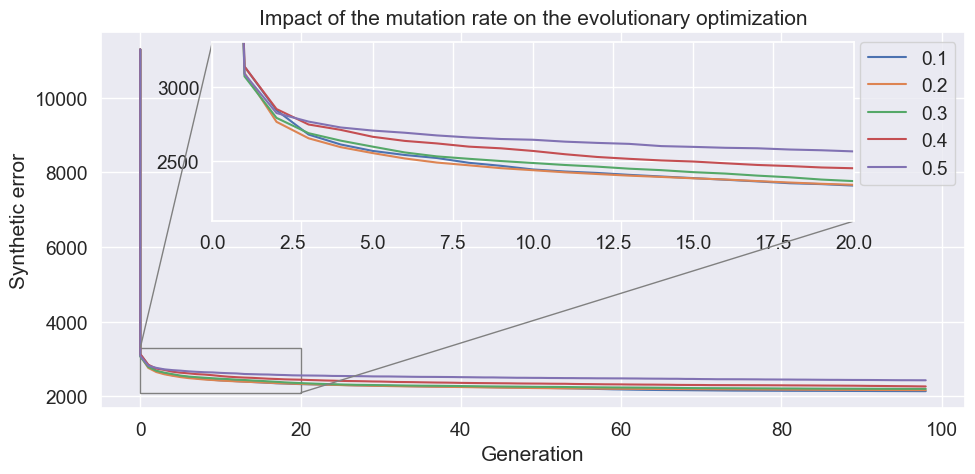

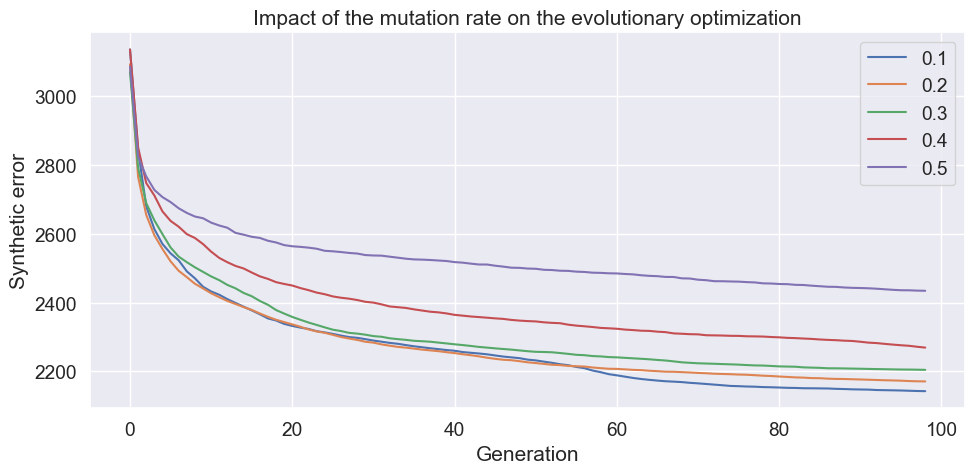

In [262]:
# calculate raptor res for using the same optimization rules as in the json:
raptor_res = None
dir_prefix = "evo_cmp_mut"

# create list with all folders starting with "EvAlg":
folders = [f for f in os.listdir(f"{base_dir}/{working_dir}") if f.startswith(dir_prefix)]
for include_raptor in [True, False]:
    res = {}

    if img_format != "":
        fig, ax1 = plt.subplots(figsize=(10, 5))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_title("Impact of the mutation rate on the evolutionary optimization")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Synthetic error")

    for folder in sorted(folders):
        print(folder)
        # load csv "_ev_optimization_log.csv":
        content = load_json(f"{base_dir}/{working_dir}/{folder}/evo_opt_state.json")
        if raptor_res is None:
            raptor_res = recalculate_for_dist(content, use_raptor_dist=True).to_json()
        gen_calc_err = pd.DataFrame(content["gen_calculated_error"])
        if include_raptor:
            #df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
        res[folder.replace(dir_prefix + "_", "")] = content
        ax1.plot(gen_calc_err, label=folder.replace(dir_prefix + "_", ""))
        # show labels in a legend:
        #ax1.tick_params(axis="y", labelcolor="tab:blue")

    #extent = (0, 512, 0, 512)
    if include_raptor:  # subregion of the original image
        axins = zoomed_inset_axes(ax1, 4, loc="upper center")
        #ax1.inset_axes(
        #[0, 100, 0, 50],
        #xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

        gen_calc_err_min = 8000
        gen_calc_err_min_max = -8000
        for name in sorted(res):
            gen_calc_err = pd.DataFrame(res[name]["gen_calculated_error"])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
            gen_calc_err = gen_calc_err.reset_index(drop=True)
            curr_min = min(gen_calc_err.values)
            gen_calc_err_min = curr_min if curr_min < gen_calc_err_min else gen_calc_err_min
            gen_calc_err_min_max = curr_min if curr_min > gen_calc_err_min_max else gen_calc_err_min_max
            axins.plot(gen_calc_err, label=name.replace(dir_prefix + "_", ""))

        axins.set_xlim(0, 20)
        lower_bound = (gen_calc_err_min // 100) * 100
        upper_bound = (gen_calc_err_min_max // 100) * 100 + 900
        axins.set_ylim(lower_bound, upper_bound)
        mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        #ax1.indicate_inset_zoom(axins, edgecolor="black")
    #fig.tight_layout()
    ax1.legend()
    plt.draw()

    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
                format="svg", dpi=1200)
    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
                bbox_inches="tight")
    print(f"Saved as {'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg/pdf")


25
Creating packet 0 / 65536
50
75
100
125
150


C:\TEMP\ipykernel_33760\564347773.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.draw()
C:\TEMP\ipykernel_33760\564347773.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
C:\TEMP\ipykernel_33760\564347773.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
C:\TEMP\ipykernel_33760\564347773.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",


Saved as including_raptor_cmp_results_evo_cmp_pop_10_5.svg/pdf
25
50
75
100
125
150
Saved as cmp_results_evo_cmp_pop_10_5.svg/pdf


D:\PycharmProjects\OFC4DNA\twichplay\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


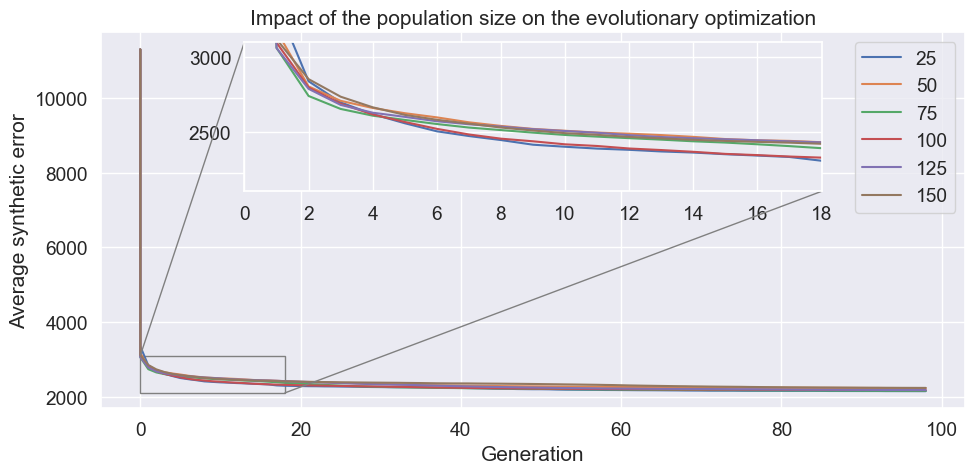

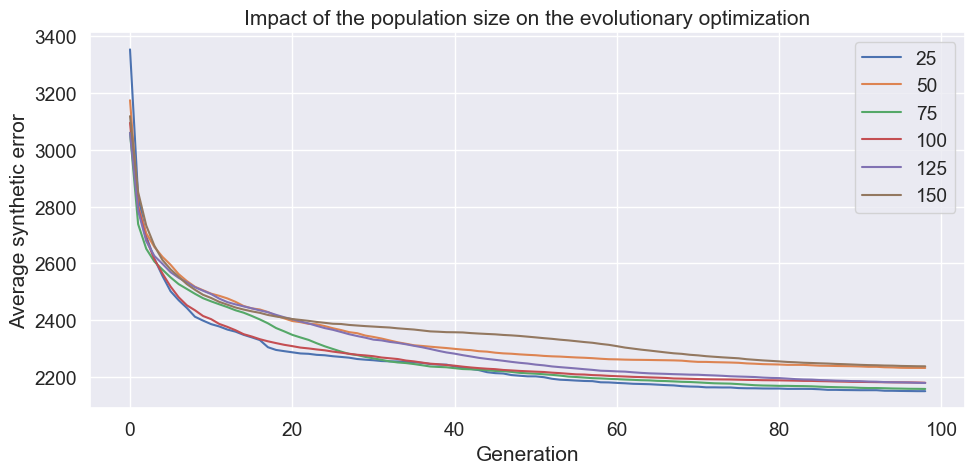

In [263]:
# create list with all folders starting with "EvAlg":
dir_prefix = "evo_cmp_pop"
folders = [f for f in os.listdir(f"{base_dir}/{working_dir}") if f.startswith(dir_prefix)]
folders = [int(folder.replace(dir_prefix + "_", "")) for folder in folders]

# calculate raptor res for using the same optimization rules as in the json:
raptor_res = None

for include_raptor in [True, False]:
    res = {}

    if img_format != "":
        fig, ax1 = plt.subplots(figsize=(10, 5))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_title("Impact of the population size on the evolutionary optimization")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Average synthetic error")
    for folder in sorted(folders):
        print(folder)
        # load csv "_ev_optimization_log.csv":
        content = load_json(f"{base_dir}/{working_dir}/{dir_prefix}_{folder}/evo_opt_state.json")
        if raptor_res is None:
            raptor_res = recalculate_for_dist(content, use_raptor_dist=True).to_json()
        gen_calc_err = pd.DataFrame(content["gen_calculated_error"])
        if include_raptor:
            #df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
        res[folder] = content
        ax1.plot(gen_calc_err, label=folder)
        # show labels in a legend:
        #ax1.tick_params(axis="y", labelcolor="tab:blue")

    #extent = (0, 512, 0, 512)
    if include_raptor:  # subregion of the original image
        axins = zoomed_inset_axes(ax1, 4, loc="upper center")
        #ax1.inset_axes(
        #[0, 100, 0, 50],
        #xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        gen_calc_err_min = 8000
        gen_calc_err_min_max = -8000
        for name in sorted(res):
            gen_calc_err = pd.DataFrame(res[name]["gen_calculated_error"])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
            gen_calc_err = gen_calc_err.reset_index(drop=True)
            curr_min = min(gen_calc_err.values)
            gen_calc_err_min = curr_min if curr_min < gen_calc_err_min else gen_calc_err_min
            gen_calc_err_min_max = curr_min if curr_min > gen_calc_err_min_max else gen_calc_err_min_max
            axins.plot(gen_calc_err, label=name)

        axins.set_xlim(0, 18)
        lower_bound = (gen_calc_err_min // 100) * 100
        upper_bound = (gen_calc_err_min_max // 100) * 100 + 900
        axins.set_ylim(lower_bound, upper_bound)
        mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        #ax1.indicate_inset_zoom(axins, edgecolor="black")
    #fig.tight_layout()
    ax1.legend()
    plt.draw()

    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
                format="svg", dpi=1200)
    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
                bbox_inches="tight")
    print(f"Saved as {'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg/pdf")


## compare different hyperparameters for Differential Evolution:

diff_cmp_f_0.7
Creating packet 0 / 65536
diff_cmp_f_0.8
diff_cmp_f_0.9
diff_cmp_f_1.0


C:\TEMP\ipykernel_33760\2823080677.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.draw()
C:\TEMP\ipykernel_33760\2823080677.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
C:\TEMP\ipykernel_33760\2823080677.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
C:\TEMP\ipykernel_33760\2823080677.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",


Saved as including_raptor_cmp_results_diff_cmp_f_10_5.svg/pdf
diff_cmp_f_0.7
diff_cmp_f_0.8
diff_cmp_f_0.9
diff_cmp_f_1.0
Saved as cmp_results_diff_cmp_f_10_5.svg/pdf


D:\PycharmProjects\OFC4DNA\twichplay\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


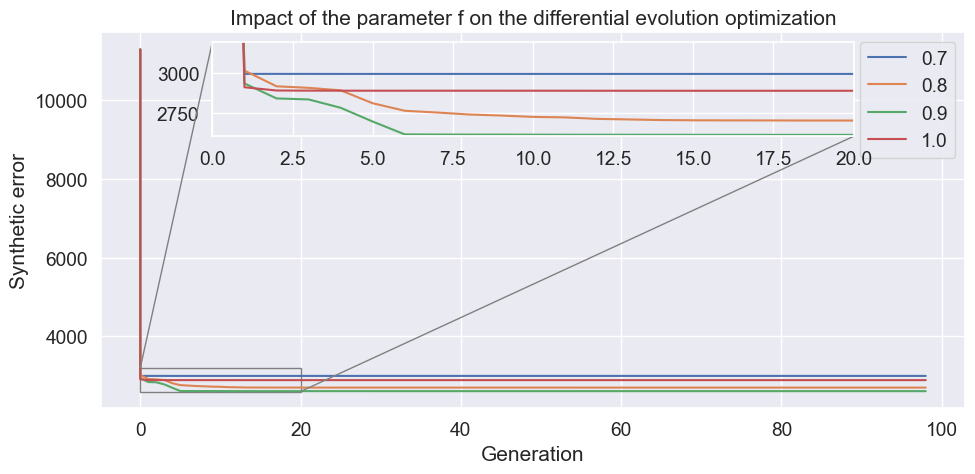

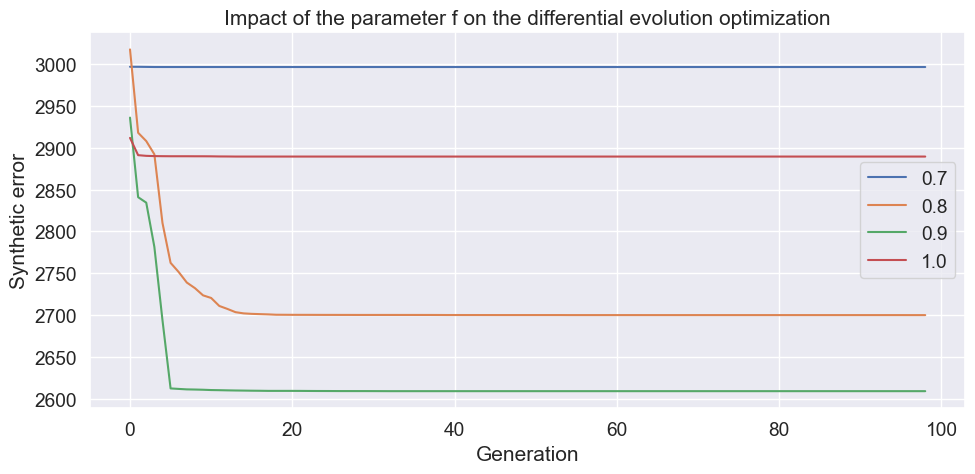

In [264]:
working_dir = "cmp_results"
dir_prefix = "diff_cmp_f"

folders = [f for f in os.listdir(f"{base_dir}/{working_dir}") if f.startswith(dir_prefix)]

# calculate raptor res for using the same optimization rules as in the json:
raptor_res = None

for include_raptor in [True, False]:
    res = {}

    if img_format != "":
        fig, ax1 = plt.subplots(figsize=(10, 5))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_title("Impact of the parameter f on the differential evolution optimization")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Synthetic error")

    for folder in sorted(folders):
        print(folder)
        # load csv "_ev_optimization_log.csv":
        content = load_json(f"{base_dir}/{working_dir}/{folder}/diff_opt_state.json")
        if raptor_res is None:
            raptor_res = recalculate_for_dist(content, use_raptor_dist=True).to_json()
        gen_calc_err = pd.DataFrame(content["gen_calculated_error"])
        if include_raptor:
            #df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
        res[folder.replace(dir_prefix + "_", "")] = content
        ax1.plot(gen_calc_err, label=folder.replace(dir_prefix + "_", ""))
        # show labels in a legend:
        #ax1.tick_params(axis="y", labelcolor="tab:blue")

    #extent = (0, 512, 0, 512)
    if include_raptor:  # subregion of the original image
        axins = zoomed_inset_axes(ax1, 4, loc="upper center")
        #ax1.inset_axes(
        #[0, 100, 0, 50],
        #xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        gen_calc_err_min = 8000
        gen_calc_err_min_max = -8000
        for name in sorted(res):
            gen_calc_err = pd.DataFrame(res[name]["gen_calculated_error"])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
            gen_calc_err = gen_calc_err.reset_index(drop=True)
            curr_min = min(gen_calc_err.values)
            gen_calc_err_min = curr_min if curr_min < gen_calc_err_min else gen_calc_err_min
            gen_calc_err_min_max = curr_min if curr_min > gen_calc_err_min_max else gen_calc_err_min_max
            axins.plot(gen_calc_err, label=name.replace(dir_prefix + "_", ""))

        axins.set_xlim(0, 20)
        lower_bound = (gen_calc_err_min // 100) * 100
        upper_bound = (gen_calc_err_min_max // 100) * 100 + 300
        axins.set_ylim(lower_bound, upper_bound)

        mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        #ax1.indicate_inset_zoom(axins, edgecolor="black")
    #fig.tight_layout()
    ax1.legend()
    plt.draw()

    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
                format="svg", dpi=1200)
    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
                bbox_inches="tight")
    print(f"Saved as {'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg/pdf")


cmp_diff_opt_cr_0.1
Creating packet 0 / 65536
cmp_diff_opt_cr_0.2
cmp_diff_opt_cr_0.4
cmp_diff_opt_cr_0.6
cmp_diff_opt_cr_0.8


C:\TEMP\ipykernel_33760\4153973840.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.draw()
C:\TEMP\ipykernel_33760\4153973840.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
C:\TEMP\ipykernel_33760\4153973840.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
C:\TEMP\ipykernel_33760\4153973840.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",


Saved as including_raptor_cmp_results_cmp_diff_opt_cr_10_5.svg/pdf
cmp_diff_opt_cr_0.1
cmp_diff_opt_cr_0.2
cmp_diff_opt_cr_0.4
cmp_diff_opt_cr_0.6
cmp_diff_opt_cr_0.8
Saved as cmp_results_cmp_diff_opt_cr_10_5.svg/pdf


D:\PycharmProjects\OFC4DNA\twichplay\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


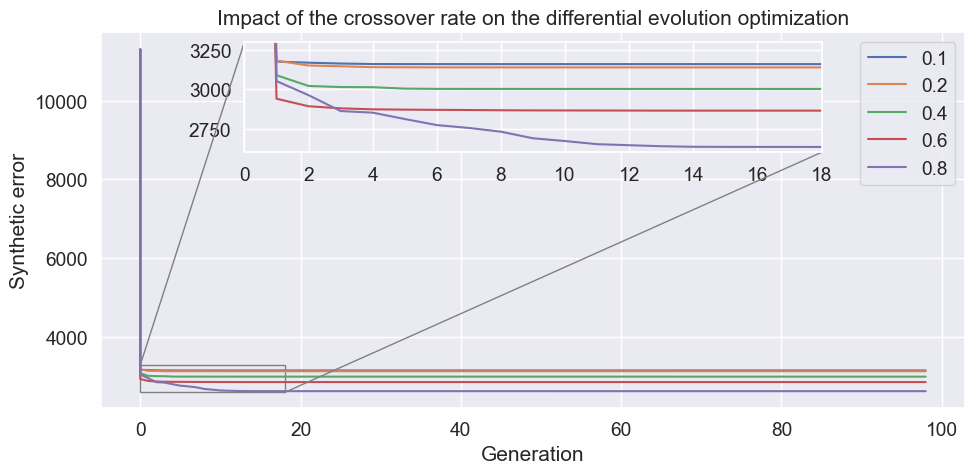

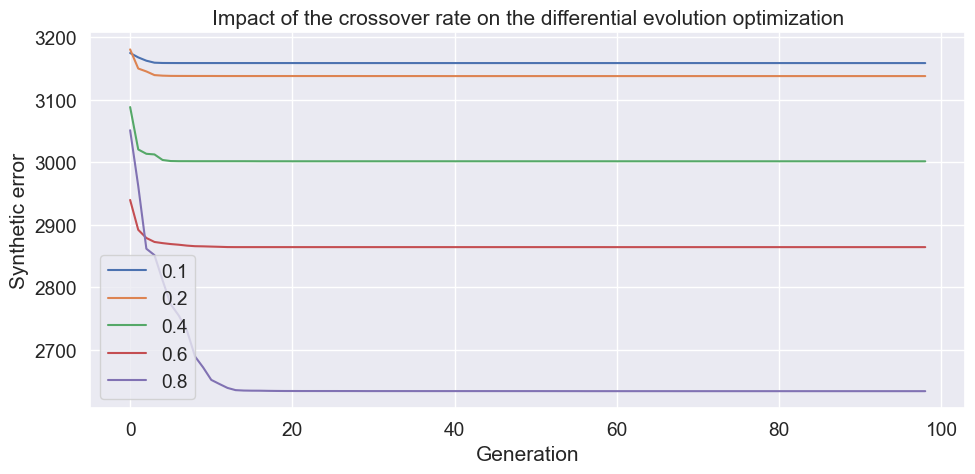

In [265]:
dir_prefix = "cmp_diff_opt_cr"
folders = [f for f in os.listdir(f"{base_dir}/{working_dir}") if f.startswith(dir_prefix)]

# calculate raptor res for using the same optimization rules as in the json:
raptor_res = None

for include_raptor in [True, False]:
    res = {}

    if img_format != "":
        fig, ax1 = plt.subplots(figsize=(10, 5))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_title("Impact of the crossover rate on the differential evolution optimization")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Synthetic error")

    for folder in sorted(folders):
        print(folder)
        # load csv "_ev_optimization_log.csv":
        content = load_json(f"{base_dir}/{working_dir}/{folder}/diff_opt_state.json")
        if raptor_res is None:
            raptor_res = recalculate_for_dist(content, use_raptor_dist=True).to_json()
        gen_calc_err = pd.DataFrame(content["gen_calculated_error"])
        if include_raptor:
            #df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
        res[folder.replace(dir_prefix + "_", "")] = content
        ax1.plot(gen_calc_err, label=folder.replace(dir_prefix + "_", ""))
        # show labels in a legend:
        #ax1.tick_params(axis="y", labelcolor="tab:blue")

    #extent = (0, 512, 0, 512)
    if include_raptor:  # subregion of the original image
        axins = zoomed_inset_axes(ax1, 4, loc="upper center")
        #ax1.inset_axes(
        #[0, 100, 0, 50],
        #xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        gen_calc_err_min = 8000
        gen_calc_err_min_max = -8000
        for name in sorted(res):
            gen_calc_err = pd.DataFrame(res[name]["gen_calculated_error"])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
            gen_calc_err = gen_calc_err.reset_index(drop=True)
            curr_min = min(gen_calc_err.values)
            gen_calc_err_min = curr_min if curr_min < gen_calc_err_min else gen_calc_err_min
            gen_calc_err_min_max = curr_min if curr_min > gen_calc_err_min_max else gen_calc_err_min_max
            axins.plot(gen_calc_err, label=name.replace(dir_prefix + "_", ""))

        axins.set_xlim(0, 18)
        lower_bound = (gen_calc_err_min // 100) * 100
        upper_bound = (gen_calc_err_min_max // 100) * 100 + 200
        axins.set_ylim(lower_bound, upper_bound)

        mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        #ax1.indicate_inset_zoom(axins, edgecolor="black")
    #fig.tight_layout()
    ax1.legend()
    plt.draw()

    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
                format="svg", dpi=1200)
    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
                bbox_inches="tight")
    print(f"Saved as {'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg/pdf")


GrdOpt_100_10_alpha_0.0001
Creating packet 0 / 65536
GrdOpt_100_10_alpha_0.001
GrdOpt_100_10_alpha_0.01
GrdOpt_100_10_alpha_0.1
GrdOpt_100_10_alpha_0.2
GrdOpt_100_10_alpha_0.3
Saved as including_raptor_cmp_results_GrdOpt_100_10_alpha_10_5.svg/pdf
GrdOpt_100_10_alpha_0.0001
GrdOpt_100_10_alpha_0.001
GrdOpt_100_10_alpha_0.01
GrdOpt_100_10_alpha_0.1
GrdOpt_100_10_alpha_0.2
GrdOpt_100_10_alpha_0.3
Saved as cmp_results_GrdOpt_100_10_alpha_10_5.svg/pdf


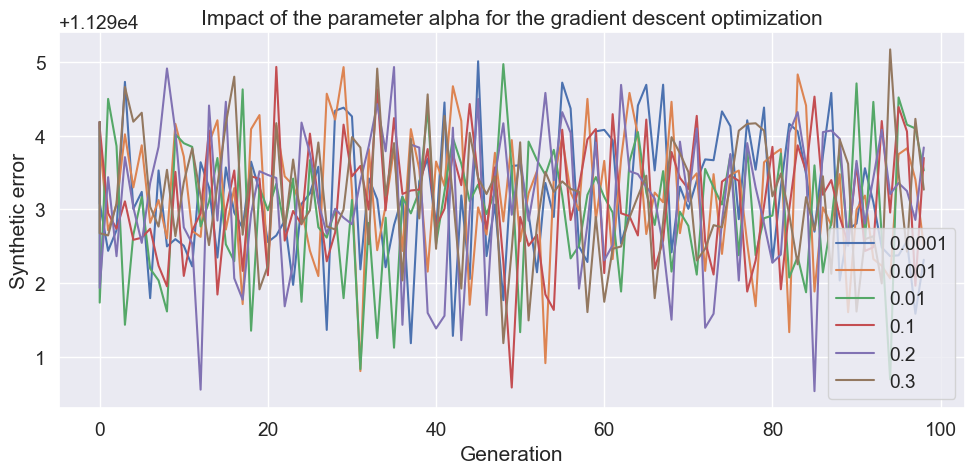

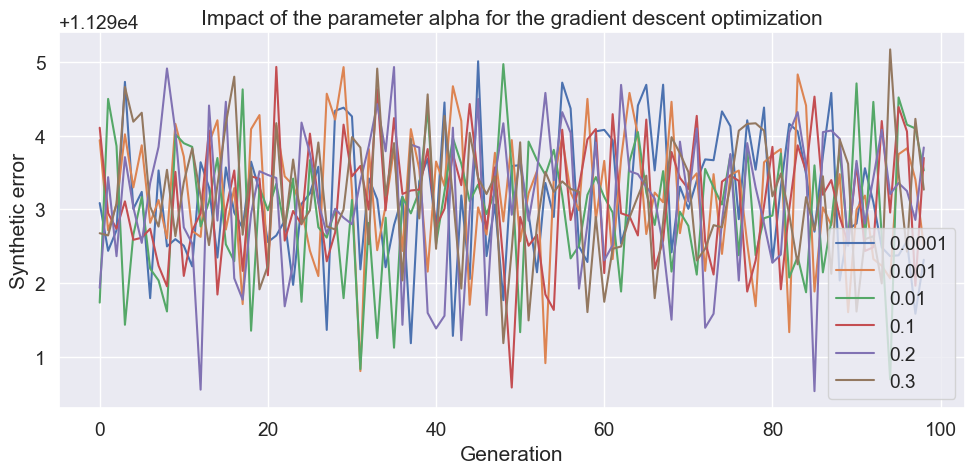

In [266]:
dir_prefix = "GrdOpt_100_10_alpha"

folders = [f for f in os.listdir(f"{base_dir}/{working_dir}") if f.startswith(dir_prefix)]

# calculate raptor res for using the same optimization rules as in the json:
raptor_res = None

for include_raptor in [True, False]:
    res = {}

    if img_format != "":
        fig, ax1 = plt.subplots(figsize=(10, 5))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_title("Impact of the parameter alpha for the gradient descent optimization")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Synthetic error")

    for folder in sorted(folders):
        print(folder)
        # load csv "_ev_optimization_log.csv":
        content = load_json(f"{base_dir}/{working_dir}/{folder}/grd_opt_state.json")
        if raptor_res is None:
            raptor_res = recalculate_for_dist(content, use_raptor_dist=True).to_json()
        gen_calc_err = pd.DataFrame([x["calculated_error_value"] for x in content["finished_gen"]])
        if include_raptor:
            #df_diff = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_diff])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
        res[folder.replace(dir_prefix + "_", "")] = content
        ax1.plot(gen_calc_err, label=folder.replace(dir_prefix + "_", ""))
        # show labels in a legend:
        #ax1.tick_params(axis="y", labelcolor="tab:blue")

    #extent = (0, 512, 0, 512)
    """
    if include_raptor: # subregion of the original image
        axins = zoomed_inset_axes(ax1, 4, loc="upper center")
            #ax1.inset_axes(
            #[0, 100, 0, 50],
            #xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        for name in sorted(res):
            gen_calc_err = pd.DataFrame(res[name]["gen_calculated_error"])
            gen_calc_err = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], gen_calc_err])
            gen_calc_err = gen_calc_err.reset_index(drop=True)
            axins.plot(gen_calc_err, label=name.replace(dir_prefix+"_",""))

        axins.set_xlim(0,20)
        axins.set_ylim(2500,3200)

        mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        #ax1.indicate_inset_zoom(axins, edgecolor="black")
    #fig.tight_layout()
    """
    # set legend position bottom right:
    ax1.legend(loc="lower right")
    plt.draw()

    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg",
                format="svg", dpi=1200)
    plt.savefig(f"{'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.pdf",
                bbox_inches="tight")
    print(f"Saved as {'including_raptor_' if include_raptor else ''}{working_dir}_{dir_prefix}{img_format}.svg/pdf")


In [267]:
# working_dir = "/from_server2/results_Dorn_only"
working_dir = "results_final_same_params"
filename1 = "results_evo/evo_opt_state.json"
filename2 = "results_diff/diff_opt_state.json/diff_opt_state.json"
filename3 = "GrdOpt_250_10_0.001results_grd/grd_opt_state.json"

json_evo = load_json(f"{base_dir}/{working_dir}/{filename1}")
json_diff = load_json(f"{base_dir}/{working_dir}/{filename2}")
json_grd = load_json(f"{base_dir}/{working_dir}/{filename3}")

In [268]:
gen_avg_err = []
gen_avg_over = []
gen_calc_err = []
gen_clean_deg_len = []
for gen in json_grd["finished_gen"]:
    gen_avg_err.append(gen["avg_err"])
    gen_clean_deg_len.append(gen["clean_deg_len"])
    gen_avg_over.append(gen["overhead"])
    gen_calc_err.append(gen["calculated_error_value"])
json_grd["gen_avg_err"] = gen_avg_err
json_grd["gen_avg_over"] = gen_avg_over
json_grd["gen_calculated_error"] = gen_calc_err

In [269]:
# assert that the results are comparable:
dirty = False
for key in json_diff.keys():
    if "_fac" in key:
        if json_evo[key] != json_diff[key] or json_grd[key] != json_diff[key]:
            dirty = True
            print(f"{key}: {json_evo[key]} (evo) != {json_diff[key]} (diff)")
if not dirty:
    print("All hyperparameters are equal")

All hyperparameters are equal


Saved file as: results_final_same_params_results_evo_results_diff_comparison_syn_err_10_5.pdf/.svg
Saved file as: results_final_same_params_results_evo_results_diff_comparison_overhead_10_5.pdf/.svg
Saved file as: results_final_same_params_results_evo_results_diff_comparison_avg_err_10_5.pdf/.svg


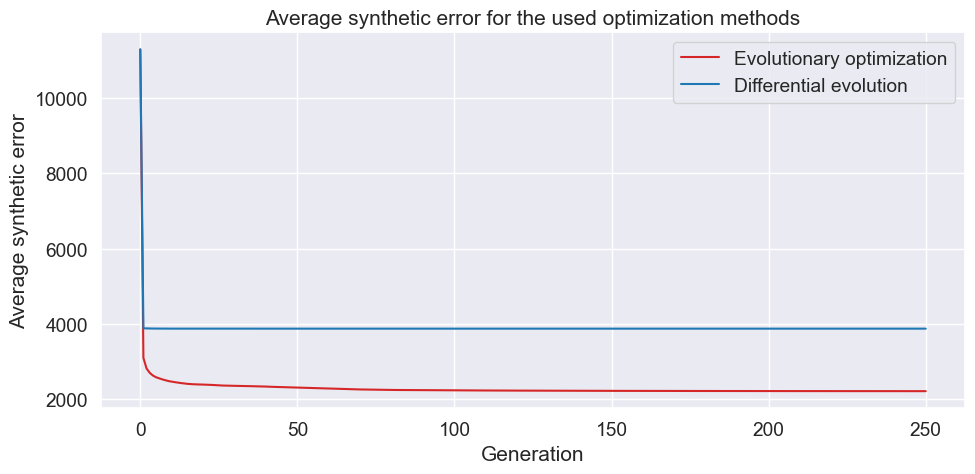

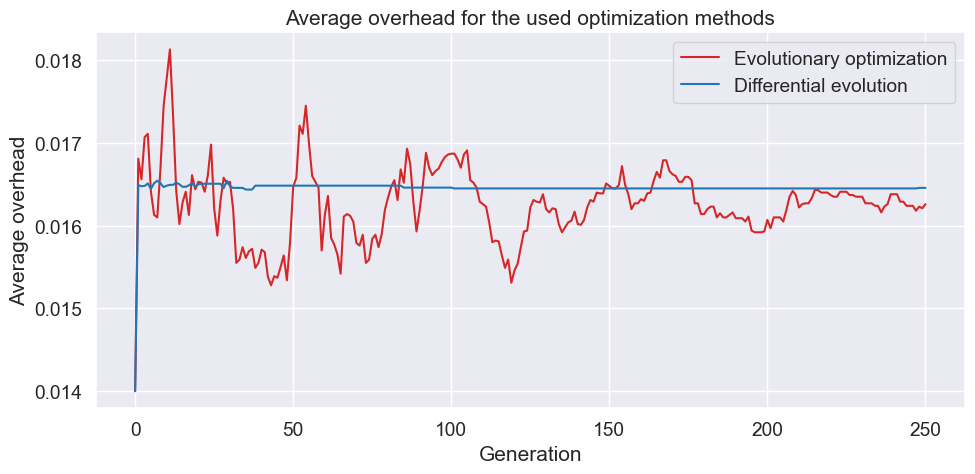

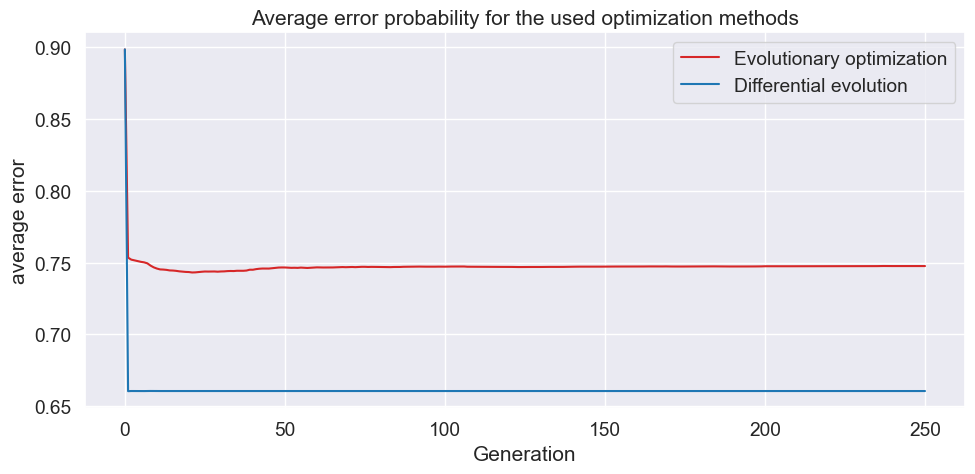

In [270]:
# avg_unrecovered packets and synthetic error value for Evolutionary Optimization
for mode in ["syn_err", "overhead", "avg_err"]:
    if img_format != "":
        fig, ax1 = plt.subplots(figsize=(10, 5))
    else:
        fig, ax1 = plt.subplots()
    if mode == "syn_err":
        dataframe_name = "gen_calculated_error"
        dist_name = "calculated_error_value"
        ylabel = "Average synthetic error"
        title = "Average synthetic error for the used optimization methods"
    elif mode == "overhead":
        dataframe_name = "gen_avg_over"
        dist_name = "overhead"
        ylabel = "Average overhead"
        title = "Average overhead for the used optimization methods"
    elif mode == "avg_err":
        dataframe_name = "gen_avg_err"
        dist_name = "avg_err"
        ylabel = "average error"
        title = "Average error probability for the used optimization methods"
    #elif mode == "clean_deg_len":
    #    dataframe_name = "gen_clean_deg_len"
    #    dist_name = "clean_deg_len"
    #    ylabel = "average rule abiding packets"
    #    title = "Average rule abiding packets for the used optimization methods"
    else:
        raise ValueError("Unknown mode")

    ax1.set_title(title)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel(ylabel)
    df_evo = pd.DataFrame(json_evo[dataframe_name][:250])
    df_evo = pd.concat([pd.DataFrame([raptor_res])[dist_name], df_evo])
    df_evo = df_evo.reset_index(drop=True)
    #df_evo_calc_err = df_evo
    ax1.plot(df_evo, color="tab:red", label="Evolutionary optimization")

    df_diff = pd.DataFrame(json_diff[dataframe_name][:250])
    df_diff = pd.concat([pd.DataFrame([raptor_res])[dist_name], df_diff])
    df_diff = df_diff.reset_index(drop=True)
    df_diff_calc_err = df_diff
    ax1.plot(df_diff, color="tab:blue", label="Differential evolution")
    #ax1.tick_params(axis="y", labelcolor="tab:blue")

    df_grd = pd.DataFrame(json_grd[dataframe_name][:250])
    df_grd = pd.concat([pd.DataFrame([raptor_res])[dist_name], df_grd])
    df_grd = df_grd.reset_index(drop=True)

    #df_grd = pd.concat([pd.DataFrame([raptor_res])["calculated_error_value"], df_grd])
    #df_grd_calc_err = df_grd
    #ax1.plot(df_grd, color="tab:orange", label="Differential Evolution")
    #ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax1.legend(["Evolutionary optimization", "Differential evolution"])  #, "Gradient Descent"])

    pdf_filename = f"{working_dir}_{filename1.split('/')[0]}_{filename2.split('/')[0]}_comparison_{mode}{img_format}"
    plt.savefig(pdf_filename + ".pdf", bbox_inches="tight")
    plt.savefig(pdf_filename + ".svg", format="svg", dpi=1200)
    print(f"Saved file as: {pdf_filename}.pdf/.svg")